In [134]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

# Q3) Write a function that models the log base 2 of x valid from 0.5 to 1 to an accuracy in the region better than $10^{-6}$. Use truncated Chebyshev polynomial fit to do this - np.polynomial.chebyshev.chebfit, how many terms do you need? (Use many x/y values and fit to some higher order, then only keep terms you think you'll need and drop rest, make sure to rescale the x-range before going from -1 to 1 before challing chebfit)

To meet the accuracy criterion of $10^{-6}$ we can simply filter the Chebyshev polynomial coefficients that are larger (absolute magnitude) than this value, given smaller coefficients will not influence this accuracy threshold (due to decreasing coefficient magnitude with order).

In [135]:
def trunc_chebyshev_log2(x, degree, tol=1e-6): 
    
    '''
    Function to return the best fit Chebyshev polynomial of smallest order (and its order) 
    to log2(x) between [0.5, 1] satisfying an accuracy tolerance of 1e-6.
    
    x: array-like
        array of evenly-spaced values from [0.5, 1]
    
    degree: int
        order of Chebyshev polynomial to fit before truncation
    
    tol: float
        minimum accuracy of truncated Chebyshev polynomial, default = 1e-6
    '''

    # We need to rescale the x values to be between -1 and 1 first
    x_new = x - np.min(x)
    x_new = x_new/np.max(x_new)
    x_new = 2*x_new - 1
    
    # Now evaluate log2(x)
    y = np.log2(x)
    
    # Now fit the data using numpy chebfit and evaluate residuals
    cheb_coef = np.polynomial.chebyshev.chebfit(x_new, y, degree) # get chebyshev coefficients for each degree
    trunc_cheb_coef = cheb_coef[np.abs(cheb_coef) > 1e-6] # truncate using criterion that coefs > 1e-6 stay
    
    # evaluate chebyshev poly with coeffs
    trunc_cheb_val = np.polynomial.chebyshev.chebval(x_new, trunc_cheb_coef)
    trunc_terms = len(trunc_cheb_coef) # degree of truncated chebyshev polynomial
    
    return trunc_cheb_val, trunc_terms
    

Chebyshev polynomial terms required to obtain accuracy > 1e-6: 8


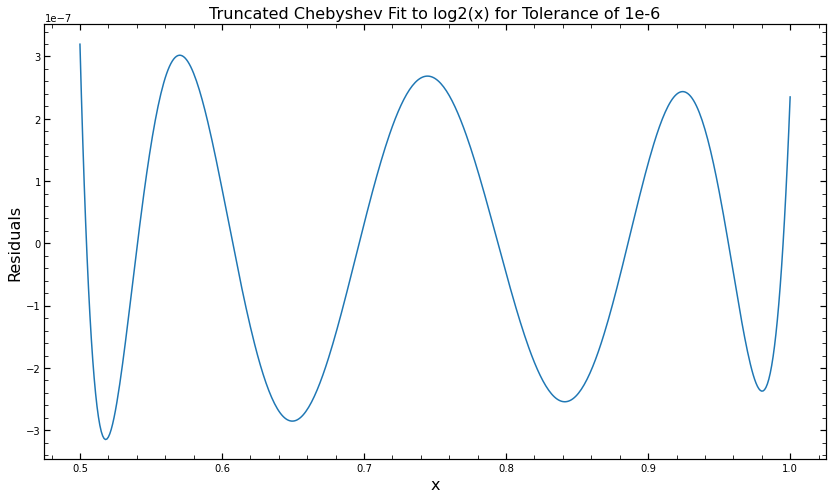

In [136]:
# Test out truncation function

npt = 501
xx = np.linspace(0.5, 1.0, npt)
yy = np.log2(xx)
trunc_cheb_fit, trunc_cheb_terms = trunc_chebyshev_log2(xx, 15) # evaluated for degree = 15

fig, ax = plt.subplots(figsize=[14, 8])
ax.plot(xx, trunc_cheb_fit - yy)
ax.set_ylabel('Residuals', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_title('Truncated Chebyshev Fit to log2(x) for Tolerance of 1e-6', fontsize=16)
print('Chebyshev polynomial terms required to obtain accuracy > 1e-6: ' + repr(trunc_cheb_terms));

Therefore, the number of terms required are 8 implying a Chebyshev polynomial of degree 7 is needed to meet the accuracy threshold. 

We can use the decomposition of an array of numbers into their mantissa and exponent and subsequently fit the $log(\text{mantissa})$ using our previously defined function, and simply add back the exponent to obtain the best fitting data given $log_2(x) = \text{exponent} + log_2(\text{mantissa})$. From here, to evaluate the natural logarithm, we use the fact that $log_n(x) = \frac{log_m(x)}{log_m(n)}$, so we can calculate the natural logarithm by dividing our best fitting data from the truncated Chebyshev fit plus the exponent from the initial decompisition by $log_2(e)$. 

In [137]:
def mylog2(x, degree):
    
    '''
    Function to evaluate the natural log of any positive number. Use same tolerance/accuracy
    in the truncated Chebyshev polynomial fit. 
    
    x:
        value to evaluate the natural log at.
    degree:
        order of Chebyshev polynomial to fit to the log2(mantissa).
    '''
    
    mantissa, exp = np.frexp(x) # Need to first decompose x into mantissa, exponent -- x = mantissa*2**exp
    trunc_cheb_fit, trunc_terms = trunc_chebyshev_log2(mantissa, degree) # call function to fit log_2(mantissa)
    trunc_cheb_fit_ln = (exp+trunc_cheb_fit)/np.log2(np.e) # now evaluate our ln fit using above formula
    
    return trunc_cheb_fit_ln, trunc_terms

Chebyshev polynomial terms required to obtain accuracy > 1e-6: 8


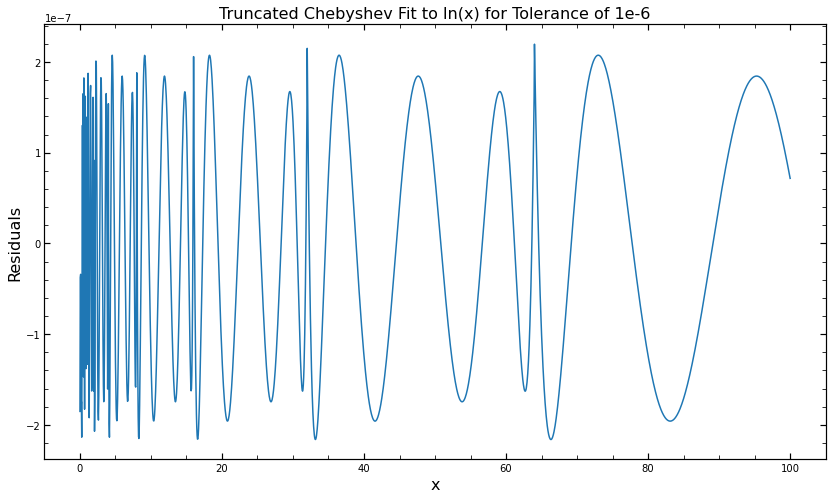

In [138]:
# Test out mylog2 to see how well it fits the natural logarithm data over a large x range

npt1 = 2001
x1 = np.linspace(0.01, 100, npt1)
y1 = np.log(x1)
trunc_cheb_fit_ln, trunc_terms1 =  mylog2(x1, 15)

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(x1, trunc_cheb_fit_ln - y1)
ax.set_ylabel('Residuals', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_title('Truncated Chebyshev Fit to ln(x) for Tolerance of 1e-6', fontsize=16)
print('Chebyshev polynomial terms required to obtain accuracy > 1e-6: ' + repr(trunc_cheb_terms));